In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import os
import openpyxl

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [4]:
final_df = pd.read_csv(processed_dir+'sims_notnull_020424.csv', index_col = [1,2])

In [5]:
final_df.drop(['Unnamed: 0', 'target', 'analogue'], axis = 1, inplace = True)

In [6]:
final_df['Label'].value_counts()

Label
1    101937
0      2665
Name: count, dtype: int64

In [7]:
final_df['Label'] = final_df['Label'].apply(lambda x: 1 if x == 0 else 0)

In [8]:
final_df['Label'].value_counts()

Label
0    101937
1      2665
Name: count, dtype: int64

In [9]:
similar_pairs = final_df[final_df['Label'] == 1]
dissimilar_pairs = final_df[final_df['Label'] ==0]

# Step 2: Downsample dissimilar pairs
downsampled_dissimilar_pairs = dissimilar_pairs.sample(n=len(similar_pairs), replace=False)

# Step 3: Combine balanced pairs
balanced_df = pd.concat([similar_pairs, downsampled_dissimilar_pairs])

# Step 4: Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [10]:
balanced_df[balanced_df['Label'] ==1]

,,Label,analogue_smi,target_smi,tanimoto,S_wl,S_trans,S_metabs,S_react,Spchem
Target,Analogue,,,,,,,,,
DTXSID9025085,DTXSID7024952,1,CCCCNCCCC,CC(C)NC(C)C,0.095238,0.000000,0.000000,0.000000,1.0,0.892139
DTXSID9026342,DTXSID7059692,1,CCCCCCCCCCCC(=O)OCC1=CC=CC=C1,OCCC1=CC=CC=C1,0.230769,0.000000,0.285714,0.000000,1.0,0.493659
DTXSID0047666,DTXSID90166240,1,CC(C)C(=O)OCC=C,CCCC(=O)OCC=C,0.382353,0.462910,0.800000,0.300000,1.0,0.996441
DTXSID9027782,DTXSID9029225,1,OC(=O)CN(CCCN(CC(O)=O)CC(O)=O)CC(O)=O,[Na+].[Fe++].OCCN(CCN(CC([O-])=O)CC([O-])=O)CC...,0.225000,0.000000,0.500000,0.000000,0.0,0.900930
DTXSID20202963,DTXSID6047604,1,CCCC(=O)OCCC1=CC=CC=C1,CCCCCCC(=O)OCC1=CC=CC=C1,0.392857,0.000000,0.300000,0.000000,1.0,0.855312
...,...,...,...,...,...,...,...,...,...,...
DTXSID5026918,DTXSID0026915,1,CCCCCCCCCCCO,CCCCCCCCCCCCO,1.000000,0.000000,1.000000,0.000000,1.0,0.968184
DTXSID7021869,DTXSID3067601,1,CC(C)CC1=CC=CC=C1O,CC1=CC=C(O)C=C1,0.166667,0.000000,0.142857,0.000000,0.0,0.892473
Pubchem_562248,DTXSID6065052,1,CCCCC(=O)OCC1=CC=CC=C1,CCCCCCCCCCC(=O)OCC1=CC=CC=C1,0.739130,0.071429,1.000000,0.272727,1.0,0.815534


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
y = balanced_df['Label'].values

In [13]:
balanced_df.columns

Index(['Label', 'analogue_smi', 'target_smi', 'tanimoto', 'S_wl', 'S_trans',
       'S_metabs', 'S_react', 'Spchem'],
      dtype='object')

In [14]:
X = balanced_df[['tanimoto', 'S_wl', 'S_trans',
       'S_metabs', 'S_react', 'Spchem']]

In [15]:
X1 = X.values

In [16]:
labels = X.columns.tolist()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, stratify = y, random_state=42)

In [18]:
coords = {"coeffs": labels}

with pm.Model(coords=coords) as model_all:
    # data containers
    
    X = pm.MutableData("X", X_train)
    y = pm.MutableData("y", y_train)
    # linear model
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    mu = pm.math.dot(X, b)
    # priors

    
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    
    pm.Bernoulli("Label", p=p, observed=y)

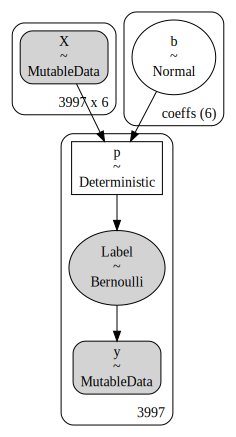

In [19]:
pm.model_to_graphviz(model_all)

In [20]:
with model_all:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


/home/grace/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/scalar/basic.py:1998: RuntimeWarning: invalid value encountered in divide
  return x / y
/home/grace/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/scalar/basic.py:1998: RuntimeWarning: invalid value encountered in divide
  return x / y
/home/grace/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/scalar/basic.py:1998: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7774 seconds.


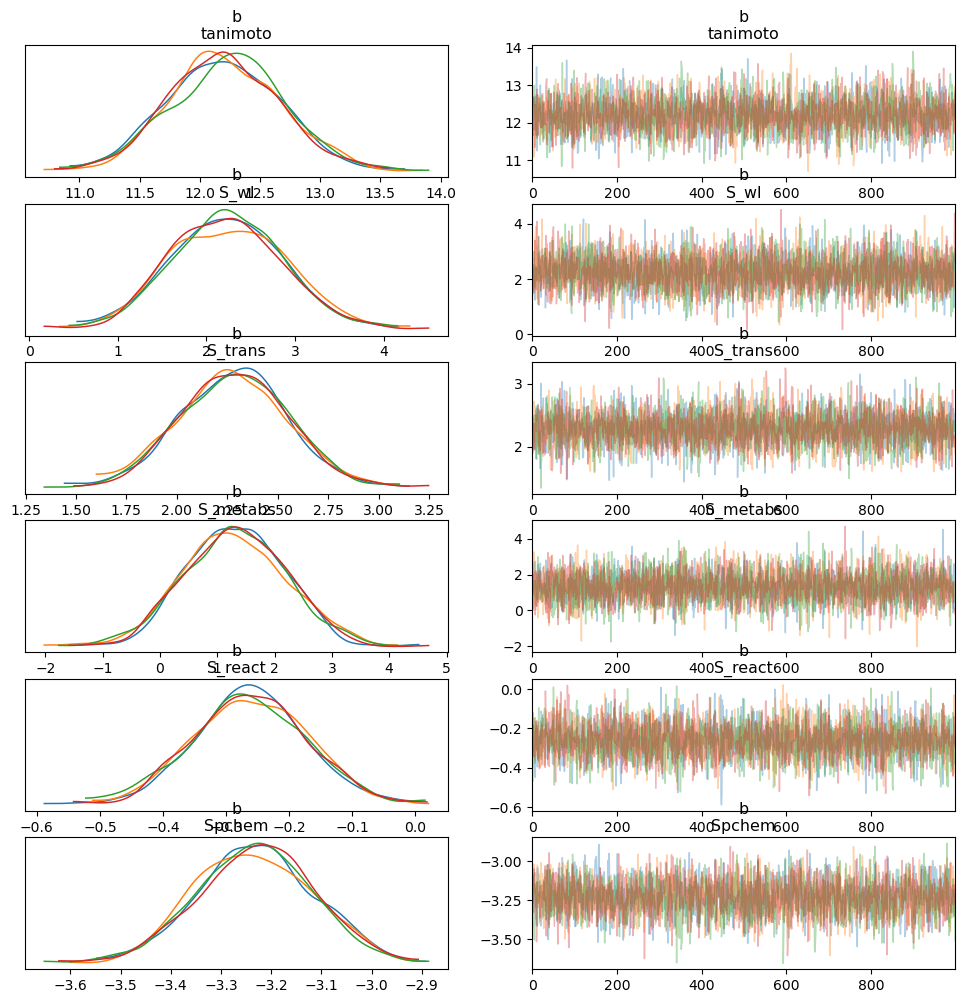

In [21]:
az.plot_trace(idata, var_names="b", compact=False);

In [22]:
az.summary(idata, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[tanimoto],12.209,0.465,11.330,13.070,0.009,0.006,2974.0,2942.0,1.0
b[S_wl],2.236,0.638,1.053,3.410,0.010,0.007,4279.0,2975.0,1.0
b[S_trans],2.282,0.269,1.790,2.790,0.004,0.003,4357.0,2786.0,1.0
b[S_metabs],1.314,0.876,-0.208,2.999,0.014,0.010,4165.0,3135.0,1.0
b[S_react],-0.262,0.090,-0.423,-0.092,0.001,0.001,3917.0,2914.0,1.0
b[Spchem],-3.232,0.114,-3.437,-3.017,0.002,0.001,3097.0,3183.0,1.0


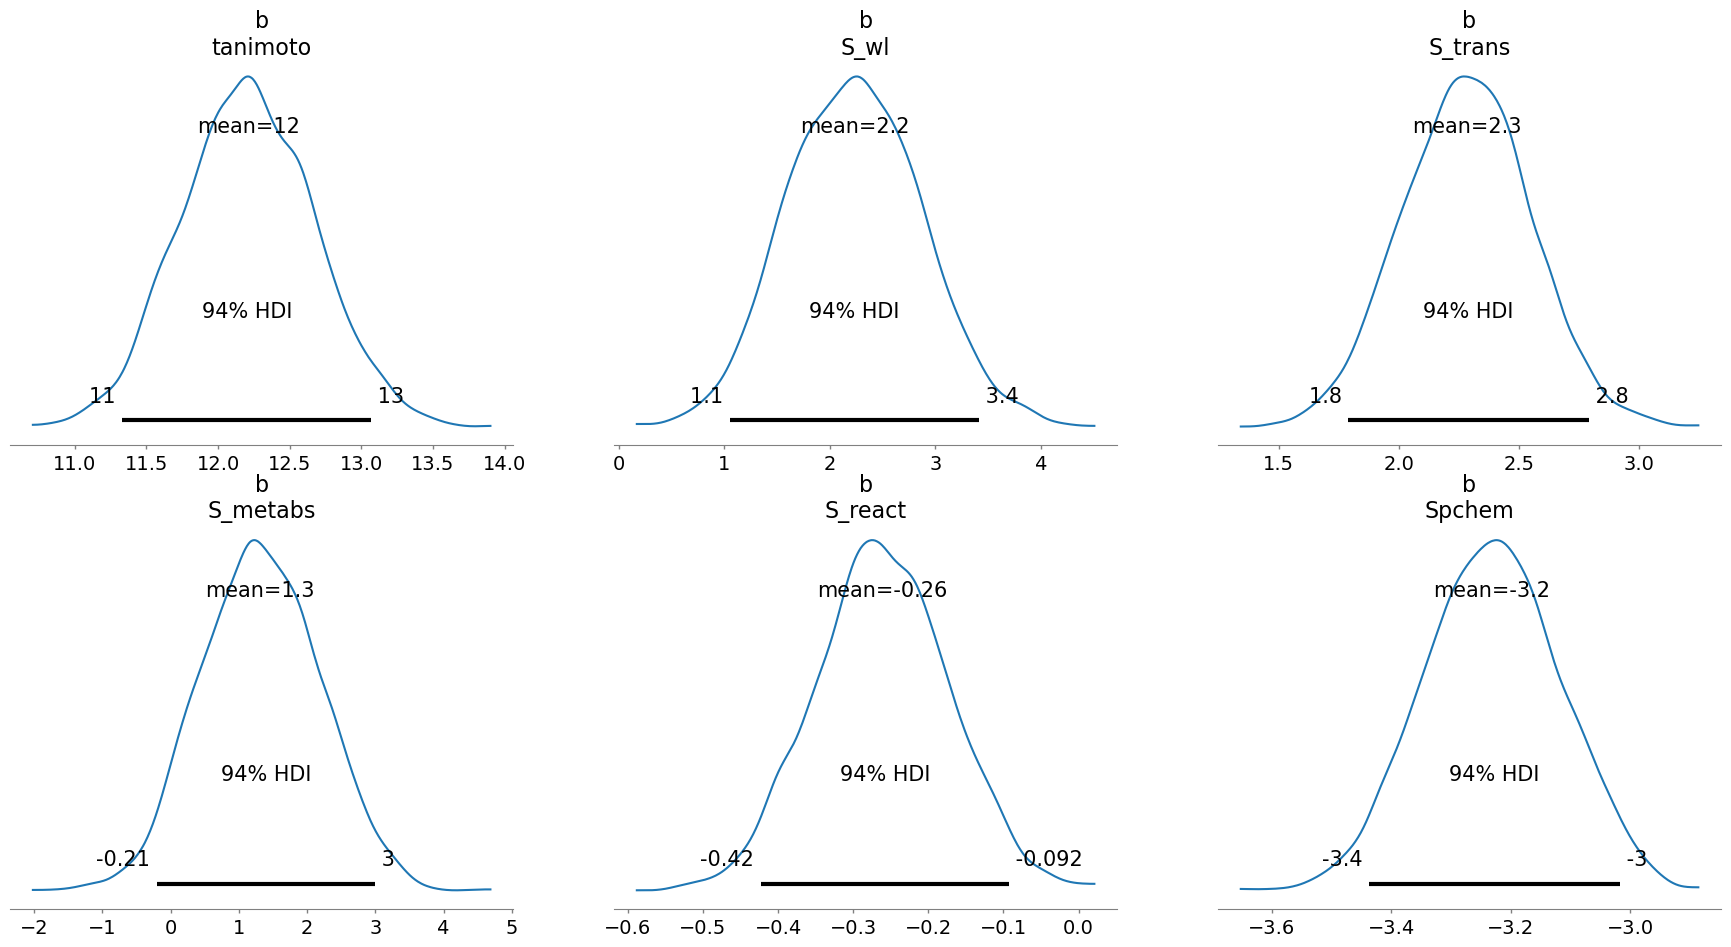

In [27]:
az.plot_posterior(
    idata, var_names=["b"],
)
plt.savefig(figures_dir+'posterior_plot.png', dpi = 300);


In [28]:
with model_all:
    pm.set_data({"X": X_test, "y": y_test})
    idata.extend(pm.sample_posterior_predictive(idata))


Sampling: [Label]


In [29]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive["Label"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()


In [30]:
print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")

accuracy =  0.830


In [31]:
from sklearn.metrics import balanced_accuracy_score

In [32]:
balanced_accuracy_score(y_test, y_test_pred)

0.8304901603252428

In [33]:
y_test_pred

array([1, 1, 0, ..., 0, 0, 1])

In [34]:
from scipy.special import expit as inverse_logit
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

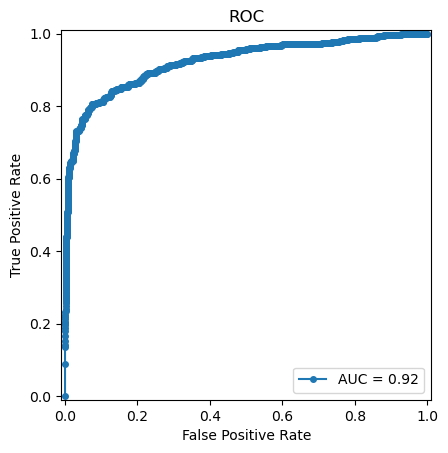

In [35]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");


In [36]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [37]:
def plot_confusion_matrix(cm, classes = ['dissimilar pair', 'analogue pair'],
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 9)
    plt.yticks(tick_marks, classes, rotation = 90, size = 9)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 9,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 9,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 9)
    plt.xlabel('Predicted Label', size = 9)
    


Confusion matrix
[[525 142]
 [ 84 582]]


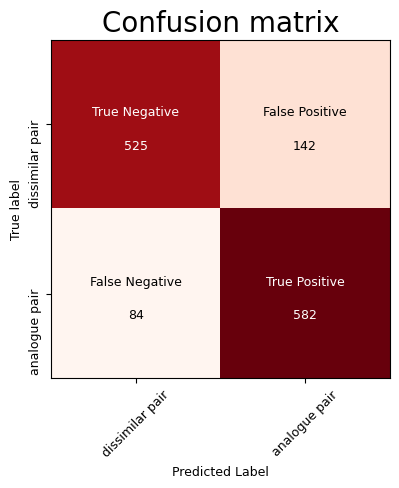

In [39]:
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm)
plt.savefig(figures_dir+'confusion matrix.png', dpi = 300)

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split

In [87]:
lr = LogisticRegression()

In [88]:
cv = StratifiedKFold(n_splits = 10)
scorer = make_scorer(balanced_accuracy_score)

In [89]:
cv_scores = cross_validate(lr, X_train, y_train, cv = cv, scoring=scorer, n_jobs = -1)
cv_scores = pd.DataFrame(cv_scores)

In [93]:
lr.fit(X_train, y_train)
preds = lr.predict(X_test)


Confusion matrix
[[627  40]
 [ 55 611]]


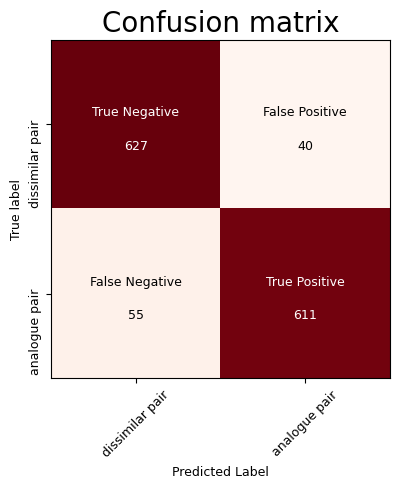

In [94]:
cm2 = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm2)

In [96]:
lr.coef_

array([[12.37206997,  2.69360884,  1.7697475 ,  1.17727927,  0.90698803,
         5.58906006]])